In [9]:
# Import modules
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import nibabel as nib
import seaborn as sns
import pandas as pd
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
import tempfile
from heteromodes.utils import unmask
from heteromodes.plotting import plot_brain

sns.set_theme(style="white")

In [10]:
hmap_labels = ["None", "layer4PC1"]
id = 1
n_subjs = 384

hmap_labels_plotting = ["Homogeneous", "PC1 gene (L4)"]

{'AUD': 0, 'VIS': 1, 'SOM': 2, 'DAN': 3, 'FPN': 4, 'VAN': 5, 'DMN': 6, 'CON': 7, 'Other': 8}


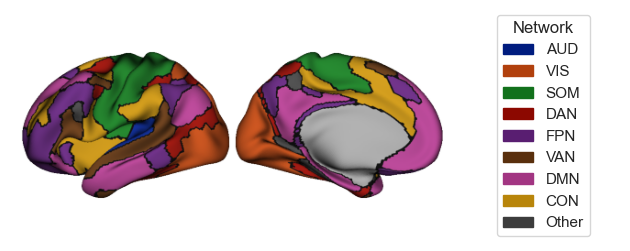

In [11]:
# Load network assignments
network_labels = np.loadtxt(f"{PROJ_DIR}/data/parcellations/Demirtas2019_NetworkLabels.L.txt", dtype=str)
network_labels = [label.split("-")[0] for label in network_labels]
net_names = ["AUD", "VIS", "SOM", "DAN", "FPN", "VAN", "DMN", "CON", "Other"]

fslr = fetch_fslr("32k")
surf = str(fslr["inflated"][0])
medmask = nib.load(fslr["medial"][0]).darrays[0].data.astype(bool)
# Get the Glasser labels (len 32k)
parc_glasser = nib.load(os.getenv("GLASSER_LH_32k")).darrays[0].data.astype(int)[medmask] - 1

# Get the network labels for each vertex
network_mapping = {net: i for i, net in enumerate(net_names)}
print(network_mapping)
network_inds = np.array([network_mapping[net] for net in network_labels])
network_vertex = unmask(network_inds[parc_glasser], medmask)    

colors = sns.color_palette("dark")
# Move the gray color to be the label for "Other"
colors.insert(8, colors.pop(7))
cmap = ListedColormap(colors, 'regions', N=len(net_names))

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.01}, figsize=(8, 3))

# Plot the network assignments
p = Plot(surf, views=['lateral', 'medial'], zoom=1.25, size=(500, 250))
p.add_layer(network_vertex + 1, cmap=cmap, cbar=False)  # +1 since 0 will be ignored in plotting
p.add_layer(unmask(network_inds[parc_glasser], medmask) + 1, as_outline=True, cmap="gray", cbar=False) # +1 since 0 will be ignored in plotting
tempfig = p.build()
plt.close(tempfig)  # Close the figure to avoid automatically displaying it
with tempfile.TemporaryDirectory() as temp_dir:
    temp_file = f"{temp_dir}/figure.png"
    tempfig.savefig(temp_file, bbox_inches='tight')

    axs[0].imshow(plt.imread(temp_file))
    axs[0].axis('off')

# Add legend
patches = [mpatches.Patch(color=colors[i], label=net_names[i]) for i in range(len(net_names))]
axs[1].legend(handles=patches, loc='center', title='Network')  # Adjust 'loc' as needed
axs[1].axis('off')

plt.show()

In [12]:
# Load empirical FC
fc_emp = h5py.File(f"{PROJ_DIR}/data/empirical/HCP_unrelated-445_rfMRI_hemi-L_nsubj-384_parc-glasser360_FCavg.hdf5")["fc"]
fc_emp = np.array(fc_emp)

# Loop through each network
within_corrs = np.empty((len(hmap_labels), len(net_names), 50)) # 50 = n_splits * n_runs
between_corrs = np.empty((len(hmap_labels), len(net_names), 50))
for i, hmap_label in enumerate(hmap_labels):
    # Load FC matrices
    with h5py.File(f"{PROJ_DIR}/results/model_rs/crossval/id-{id}/{hmap_label}/results.hdf5", "r") as f:
        fc_matrices = np.array(f["fc_test"][:])

    for j, net_name in enumerate(net_names):
        # Get indices for within and between networks
        within_inds = [ind for ind, network in enumerate(network_labels) if network.startswith(net_name)]
        within_triu_inds = np.triu_indices(len(within_inds), k=1)
        between_inds = [ind for ind, network in enumerate(network_labels) if not network.startswith(net_name)]

        # Get empirical FC for network
        fc_within_emp = fc_emp[np.ix_(within_inds, within_inds)]
        fc_between_emp = fc_emp[np.ix_(within_inds, between_inds)]

        # Loop through each FC matrix
        for k, fc_id in enumerate(range(fc_matrices.shape[2])):
            # Get simulated FC for network and compute correlation
            fc_within_sim = fc_matrices[np.ix_(within_inds, within_inds, [fc_id])].squeeze()
            within_corrs[i, j, k] = np.corrcoef(np.arctanh(fc_within_emp[within_triu_inds]), np.arctanh(fc_within_sim[within_triu_inds]))[0, 1]

            # Compute between network similarity
            fc_between_sim = fc_matrices[np.ix_(within_inds, between_inds, [fc_id])].squeeze()
            between_corrs[i, j, k] = np.corrcoef(np.arctanh(fc_between_emp.flatten()), np.arctanh(fc_between_sim.flatten()))[0, 1]

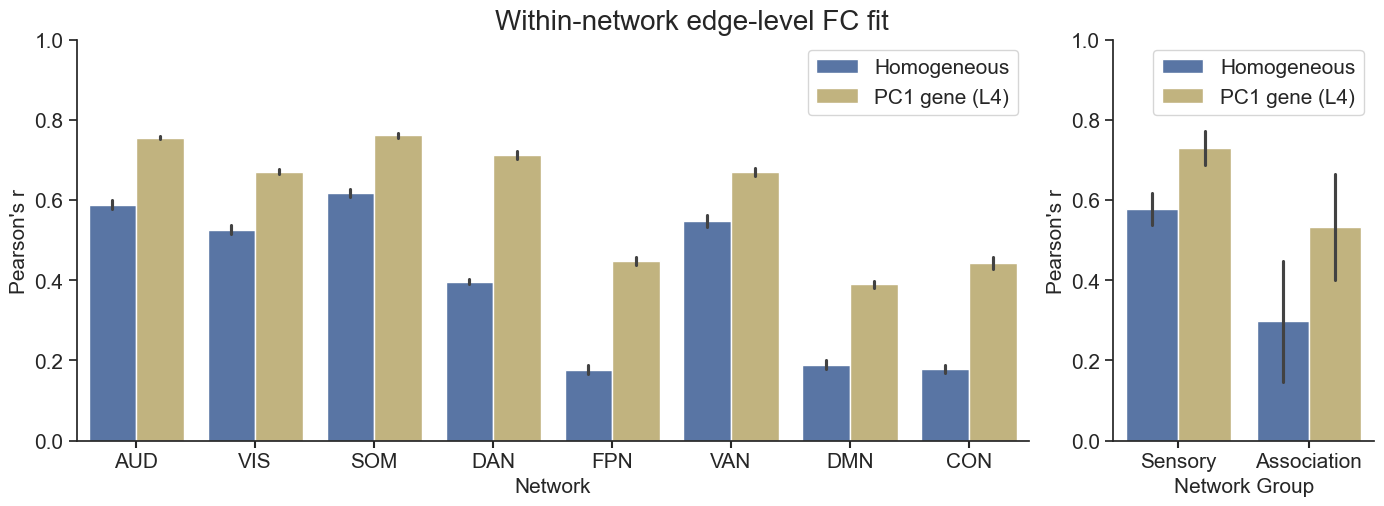

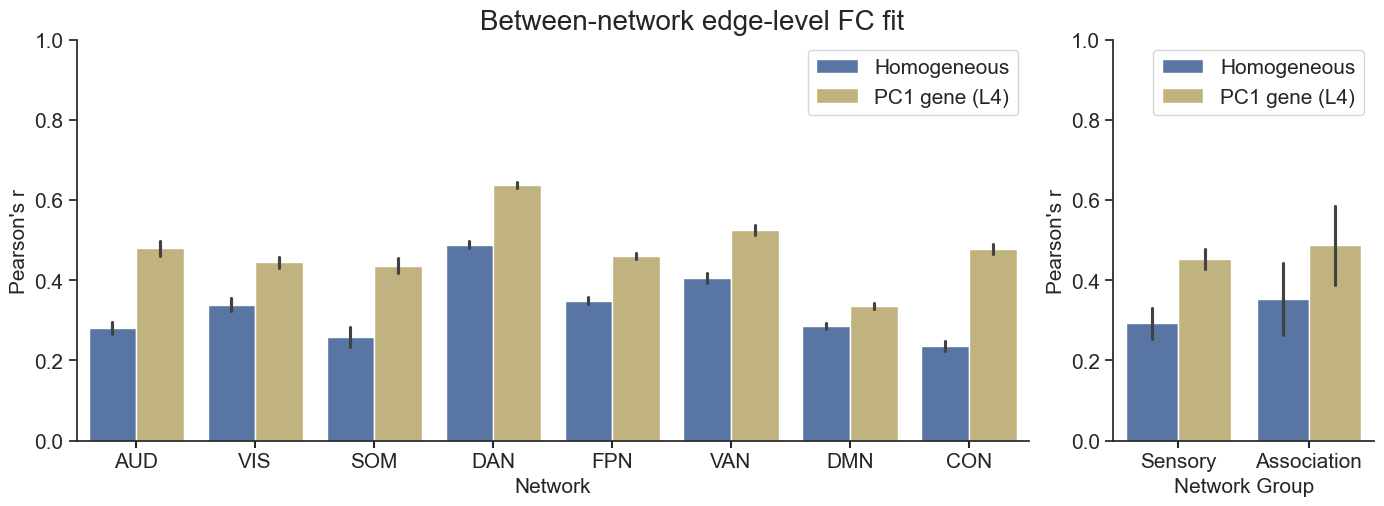

In [13]:
fs_ax = 15
fs_title = 20
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

# Define color palette
colors = [sns.color_palette()[0], sns.color_palette()[8]]

### Within-network FC similarity ###
# Reshape the within-network correlations for plotting
within_corrs_df = pd.DataFrame(
    within_corrs.reshape(len(hmap_labels) * len(net_names), 50).T,
    columns = pd.MultiIndex.from_product([hmap_labels_plotting, net_names], names=["hmap", "Network"])
).melt(var_name=["hmap", "Network"], value_name="Pearson's r")

# Specify whether network is part of the sensory or association networks
within_corrs_df["network_group"] = within_corrs_df["Network"].apply(lambda x: "Sensory" if x in ['AUD', 'VIS', 'SOM'] else "Association" if x in ['DAN', 'FPN', 'VAN', 'DMN', 'CON'] else "other")

# Create the figure and gridspec layout
fig1 = plt.figure(figsize=(14, 5))  # Adjust the overall figure size as needed
gs = gridspec.GridSpec(1, 4, figure=fig1)
# First plot: Full network breakdown
ax1 = fig1.add_subplot(gs[0, 0:3])  # First plot takes up the first three columns
sns.barplot(x="Network", y="Pearson's r", hue="hmap", order=net_names[:-1], 
            data=within_corrs_df, errorbar="sd", ax=ax1, palette=colors)
ax1.set_ylim(0, 1)
ax1.legend(loc="upper right", fontsize=fs_ax)
ax1.set_xlabel("Network", fontsize=fs_ax)
ax1.set_ylabel("Pearson's r", fontsize=fs_ax)
ax1.tick_params(axis='both', which='major', labelsize=fs_ax)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# Second plot: Grouped by network type
ax2 = fig1.add_subplot(gs[0, 3])  # Second plot takes up the fourth column
sns.barplot(x="network_group", y="Pearson's r", hue="hmap", order=["Sensory", "Association"], 
            data=within_corrs_df, errorbar="sd", ax=ax2, palette=colors)
ax2.set_ylim(0, 1)
ax2.legend(loc="upper right", fontsize=fs_ax)
ax2.set_xlabel('Network Group', fontsize=fs_ax)
ax2.set_ylabel("Pearson's r", fontsize=fs_ax)
ax2.tick_params(axis='both', which='major', labelsize=fs_ax)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
# Adjust the layout to avoid overlap
plt.tight_layout()
plt.suptitle("Within-network edge-level FC fit", y=1.01, fontsize=fs_title)

### Between-network FC similarity ###
# Reshape the between-network correlations for plotting
between_corrs_df = pd.DataFrame(
    between_corrs.reshape(len(hmap_labels) * len(net_names), 50).T,
    columns = pd.MultiIndex.from_product([hmap_labels_plotting, net_names], names=["hmap", "Network"])
).melt(var_name=["hmap", "Network"], value_name="Pearson's r")

# Specify whether network is part of the sensory or association networks
between_corrs_df["network_group"] = between_corrs_df["Network"].apply(lambda x: "Sensory" if x in ['AUD', 'VIS', 'SOM'] else "Association" if x in ['DAN', 'FPN', 'VAN', 'DMN', 'CON'] else "other")

# Create the figure and gridspec layout
fig1 = plt.figure(figsize=(14, 5))  # Adjust the overall figure size as needed
gs = gridspec.GridSpec(1, 4, figure=fig1)
# First plot: Full network breakdown
ax1 = fig1.add_subplot(gs[0, 0:3])  # First plot takes up the first three columns
sns.barplot(x="Network", y="Pearson's r", hue="hmap", order=net_names[:-1], 
            data=between_corrs_df, errorbar="sd", ax=ax1, palette=colors)
ax1.set_ylim(0, 1)
ax1.legend(loc="upper right", fontsize=fs_ax)
ax1.set_xlabel("Network", fontsize=fs_ax)
ax1.set_ylabel("Pearson's r", fontsize=fs_ax)
ax1.tick_params(axis='both', which='major', labelsize=fs_ax)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# Second plot: Grouped by network type
ax2 = fig1.add_subplot(gs[0, 3])  # Second plot takes up the fourth column
sns.barplot(x="network_group", y="Pearson's r", hue="hmap", order=["Sensory", "Association"], 
            data=between_corrs_df, errorbar="sd", ax=ax2, palette=colors)
ax2.set_ylim(0, 1)
ax2.legend(loc="upper right", fontsize=fs_ax)
ax2.set_xlabel('Network Group', fontsize=fs_ax)
ax2.set_ylabel("Pearson's r", fontsize=fs_ax)
ax2.tick_params(axis='both', which='major', labelsize=fs_ax)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
# Adjust the layout to avoid overlap
plt.tight_layout()
plt.suptitle("Between-network edge-level FC fit", y=1.01, fontsize=fs_title)

# Show the plots
plt.show()

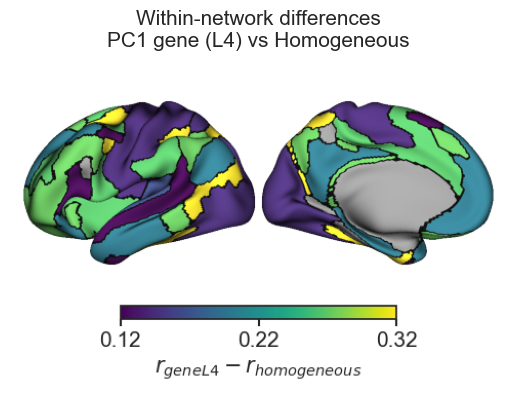

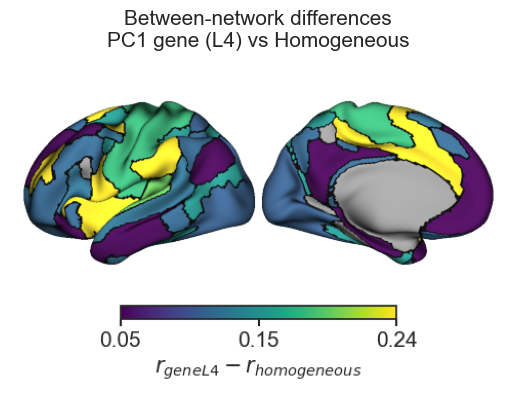

In [18]:
# Plot within-network differences on cortex
for i, hmap_label in enumerate(hmap_labels[1:]):
    # Calculate the within and between network differences
    within_diffs = np.mean(within_corrs[i+1, :, :], axis=-1) - np.mean(within_corrs[0, :, :], axis=-1)
    between_diffs = np.mean(between_corrs[i+1, :, :], axis=-1) - np.mean(between_corrs[0, :, :], axis=-1)

    # Map the network differences from network labels to vertex labels
    within_diffs_vertex = unmask(within_diffs[network_inds[parc_glasser]], medmask)
    between_diffs_vertex = unmask(between_diffs[network_inds[parc_glasser]], medmask)

    # Set vertices where network == "Other" to nan
    within_diffs_vertex[network_vertex == 8] = np.nan
    between_diffs_vertex[network_vertex == 8] = np.nan

    # Plot within-network differences
    fig1 = plot_brain(surf, data=within_diffs_vertex, cbar=True, cbar_kws=dict(fontsize=15), 
                      cbar_label="$r_{geneL4} - r_{homogeneous}$", outline=True)
    plt.title(f"Within-network differences\n{hmap_labels_plotting[i+1]} vs {hmap_labels_plotting[0]}", fontsize=15)

    # Plot bewteen-network differences
    fig2 = plot_brain(surf, data=between_diffs_vertex, cbar=True, cbar_kws=dict(fontsize=15), 
                      cbar_label="$r_{geneL4} - r_{homogeneous}$", outline=True)
    plt.title(f"Between-network differences\n{hmap_labels_plotting[i+1]} vs {hmap_labels_plotting[0]}", fontsize=15)

In [15]:
# Plot network similarity heatmap